In [1]:
!nvidia-smi

Tue Sep 12 23:42:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
|  0%   33C    P8    21W / 350W |      8MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:AF:00.0 Off |                  N/A |
|  0%   

In [2]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import math
import collections
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10
from torchvision.models import (
    alexnet, AlexNet_Weights, resnet18, ResNet18_Weights, resnet50, ResNet50_Weights,
    efficientnet_b0, EfficientNet_B0_Weights, 
    efficientnet_b1, EfficientNet_B1_Weights, 
    efficientnet_b2, EfficientNet_B2_Weights, 
    efficientnet_b3, EfficientNet_B3_Weights, 
    efficientnet_b4, EfficientNet_B4_Weights, 
)
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')

In [3]:
from importlib import reload
import valuation, utils

In [4]:
from valuation import compute_volumes, compute_X_tilde_and_counts, compute_robust_volumes, get_volume, get_relevance

In [5]:
root = Path('../data/')
download = True

mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)
fashion_seller = FashionMNIST(root=root, train=False, download=download)
emnist = EMNIST(root=root, split='byclass', train=False, download=download)

In [6]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1).cuda()

model.eval();

upsample = lambda x: torch.nn.Upsample(scale_factor=2)(x)

embed = lambda loader: torch.cat([model(x.cuda()).detach().cpu() for x in iter(loader)])

batch_size = 16
mnist_buyer_loader = torch.utils.data.DataLoader(upsample(mnist_buyer.data.unsqueeze(1).repeat(1, 3, 1, 1) / 255), batch_size=batch_size)
mnist_buyer_features = embed(mnist_buyer_loader)

mnist_seller_loader = torch.utils.data.DataLoader(upsample(mnist_seller.data.unsqueeze(1).repeat(1, 3, 1, 1) / 255), batch_size=batch_size)
mnist_seller_features = embed(mnist_seller_loader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/luchar/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


In [7]:
fashion_seller_loader = torch.utils.data.DataLoader(upsample(fashion_seller.data.unsqueeze(1).repeat(1, 3, 1, 1) / 255), batch_size=batch_size)
fashion_seller_features = embed(fashion_seller_loader)

In [8]:
buyer_data = mnist_buyer_features[
    (mnist_buyer.targets == 1)
    | ( mnist_buyer.targets == 2)
    | (mnist_buyer.targets == 3) 
    | (mnist_buyer.targets == 4)
    | (mnist_buyer.targets == 5) 
    # | (mnist_buyer.targets == 6)
]
buyer_data -= buyer_data.mean(0)
buyer_cov = np.cov(buyer_data.T)

In [53]:
n = 1000

seller_1_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    # (mnist_seller.targets == 2)
    # | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_2_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    # | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]
seller_3_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_4_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_5_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_6_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_7_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_8_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_9_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n]

seller_10_data = mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
    | (mnist_seller.targets == 0)
][:n]

seller_1_data -= seller_1_data.mean(0)
seller_2_data -= seller_2_data.mean(0)
seller_3_data -= seller_3_data.mean(0)
seller_4_data -= seller_4_data.mean(0)
seller_5_data -= seller_5_data.mean(0)
seller_6_data -= seller_6_data.mean(0)
seller_7_data -= seller_7_data.mean(0)
seller_8_data -= seller_8_data.mean(0)
seller_9_data -= seller_9_data.mean(0)
seller_10_data -= seller_10_data.mean(0)

seller_1_cov = np.cov(seller_1_data.T)
seller_2_cov = np.cov(seller_2_data.T)
seller_3_cov = np.cov(seller_3_data.T)
seller_4_cov = np.cov(seller_4_data.T)
seller_5_cov = np.cov(seller_5_data.T)
seller_6_cov = np.cov(seller_6_data.T)
seller_7_cov = np.cov(seller_7_data.T)
seller_8_cov = np.cov(seller_8_data.T)
seller_9_cov = np.cov(seller_9_data.T)
seller_10_cov = np.cov(seller_10_data.T)

In [54]:
# pca = PCA(n_components=5, svd_solver='randomized', whiten=True)
pca = PCA(n_components=25, svd_solver='randomized', whiten=False)
pca.fit(buyer_data)
pca.explained_variance_

array([1495.14080689,  318.64282078,  222.13080423,  154.84514977,
        107.72558056,   95.86468163,   81.82115319,   76.12901124,
         69.35144458,   58.59585501,   47.42856822,   39.58160908,
         35.49111097,   30.89498456,   28.95904201,   27.56967474,
         24.47795249,   22.17409294,   19.47069773,   18.86254696,
         16.24795866,   14.90053107,   13.47756708,   12.71403005,
         11.56127607])

In [55]:
def get_value(pca, seller):
    rel = valuation.get_relevance(pca, seller)
    vol = valuation.get_volume(np.cov(pca.transform(seller).T))
    return rel, vol

In [56]:
import matplotlib
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, 10).astype(int)]

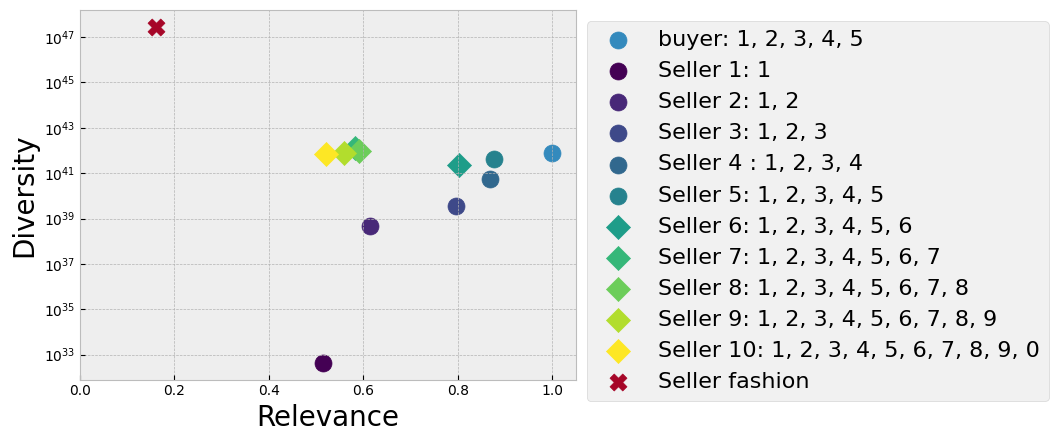

In [57]:
s = 150
plt.scatter(*get_value(pca, buyer_data), label='buyer: 1, 2, 3, 4, 5', s=s, marker='o')
plt.scatter(*get_value(pca, seller_1_data), color=colors[0], s=s, marker='o', label='Seller 1: 1')
plt.scatter(*get_value(pca, seller_2_data), color=colors[1], s=s, marker='o', label='Seller 2: 1, 2')
plt.scatter(*get_value(pca, seller_3_data), color=colors[2], s=s, marker='o', label='Seller 3: 1, 2, 3')
plt.scatter(*get_value(pca, seller_4_data), color=colors[3], s=s, marker='o', label='Seller 4 : 1, 2, 3, 4')
plt.scatter(*get_value(pca, seller_5_data), color=colors[4], s=s, marker='o', label='Seller 5: 1, 2, 3, 4, 5')
plt.scatter(*get_value(pca, seller_6_data), color=colors[5], s=s, marker='D', label='Seller 6: 1, 2, 3, 4, 5, 6')
plt.scatter(*get_value(pca, seller_7_data), color=colors[6], s=s, marker='D', label='Seller 7: 1, 2, 3, 4, 5, 6, 7')
plt.scatter(*get_value(pca, seller_8_data), color=colors[7], s=s, marker='D', label='Seller 8: 1, 2, 3, 4, 5, 6, 7, 8')
plt.scatter(*get_value(pca, seller_9_data), color=colors[8], s=s, marker='D', label='Seller 9: 1, 2, 3, 4, 5, 6, 7, 8, 9')
plt.scatter(*get_value(pca, seller_10_data),color=colors[9], s=s, marker='D', label='Seller 10: 1, 2, 3, 4, 5, 6, 7, 8, 9, 0')
plt.scatter(*get_value(pca, fashion_seller_features),color='C1', s=s, marker='X', label='Seller fashion')
plt.yscale('log')
plt.xlim(0.0, 1.05)
plt.xlabel('Relevance', fontsize=20)
plt.ylabel('Diversity', fontsize=20)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.00, 1.00), ncol=1)
# plt.savefig(f'figures/mnist-diversity.png', bbox_inches='tight')

In [58]:
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

In [59]:
def cluster_valuation(buyer_data, seller_data, k_means=None, n_clusters=10, n_components=25):
    if k_means is None:
        k_means = KMeans(n_clusters=n_clusters, n_init='auto')
        k_means.fit(buyer_data)
    buyer_clusters = {k: buyer_data[k_means.predict(buyer_data) == k] for k in range(n_clusters)}
    seller_clusters = {k: seller_data[k_means.predict(seller_data) == k] for k in range(n_clusters)}
    cluster_rel = {}
    cluster_vol = {}
    # for j in tqdm(range(n_clusters)):
    for j in range(n_clusters):
        cluster_pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
        cluster_pca.fit(buyer_clusters[j])
        ws = []
        rs = []
        vs = []
        for i in range(n_clusters):
            if seller_clusters[i].shape[0] == 0 or seller_clusters[i].shape[0] == 1:
                ws.append(0)
                rs.append(0)
                vs.append(0)
            else:
                ws.append(seller_clusters[i].shape[0] / seller_data.shape[0])
                rs.append(valuation.get_relevance(cluster_pca, seller_clusters[i]))
                vs.append(valuation.get_volume(np.cov(cluster_pca.transform(seller_clusters[i]).T)))
        cluster_rel[j] = np.average(rs, weights=ws)
        cluster_vol[j] = np.average(vs, weights=ws)
    buyer_weights = [v.shape[0] / buyer_data.shape[0] for v in buyer_clusters.values()]
    # print(buyer_weights)
    rel = np.average(list(cluster_rel.values()), weights=buyer_weights)
    vol = np.average(list(cluster_vol.values()), weights=buyer_weights)
    return rel, vol

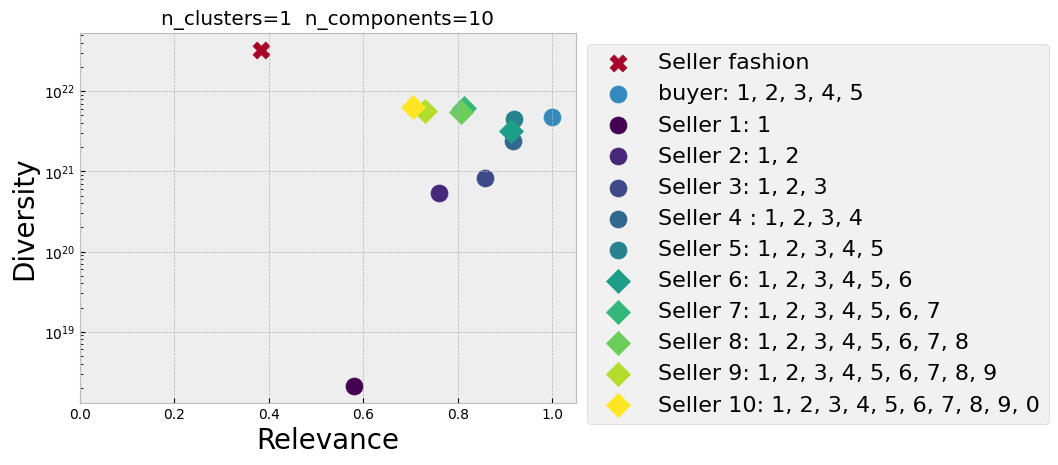

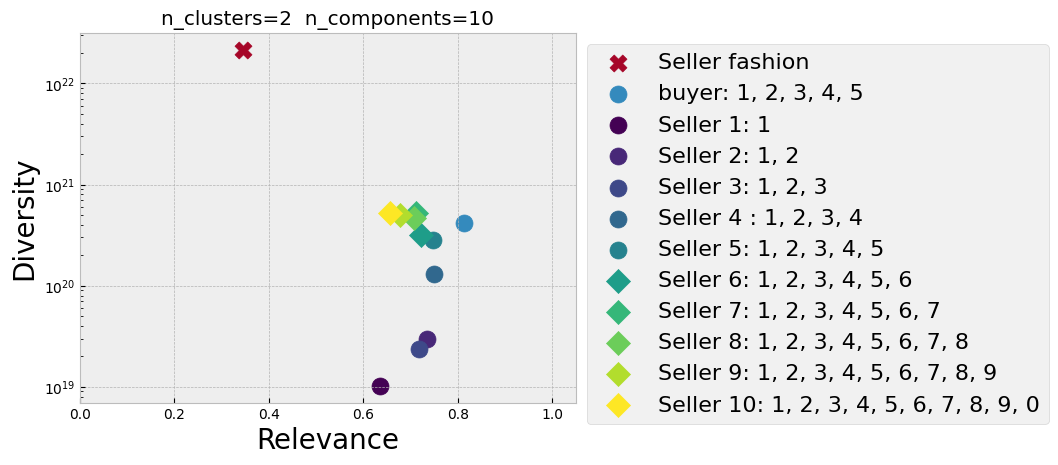

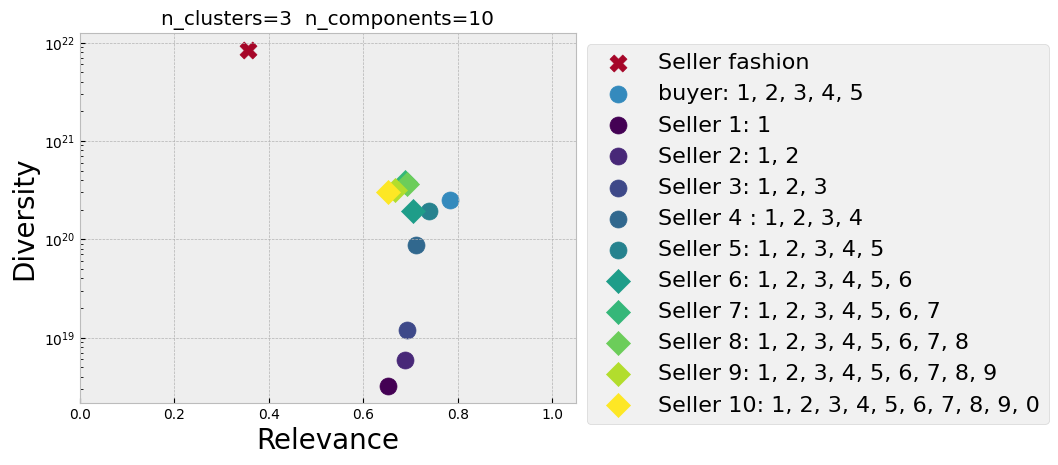

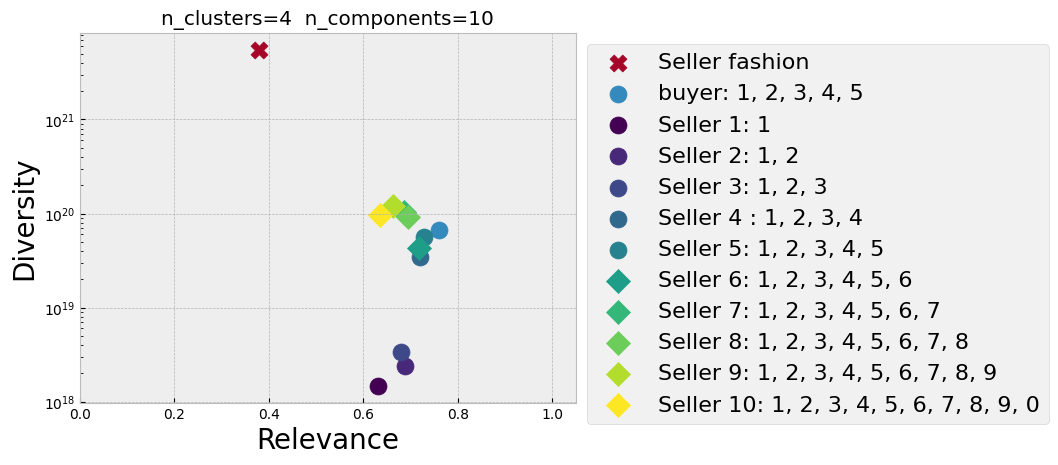

/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)


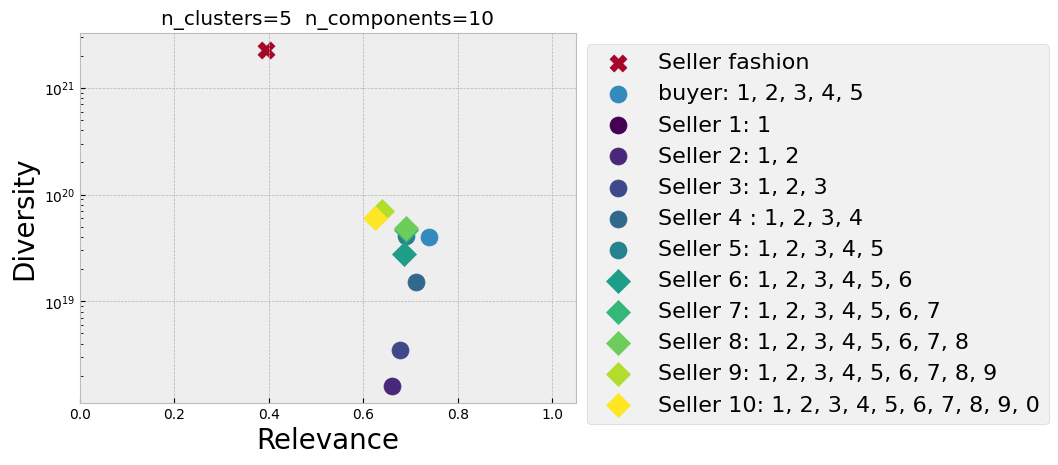

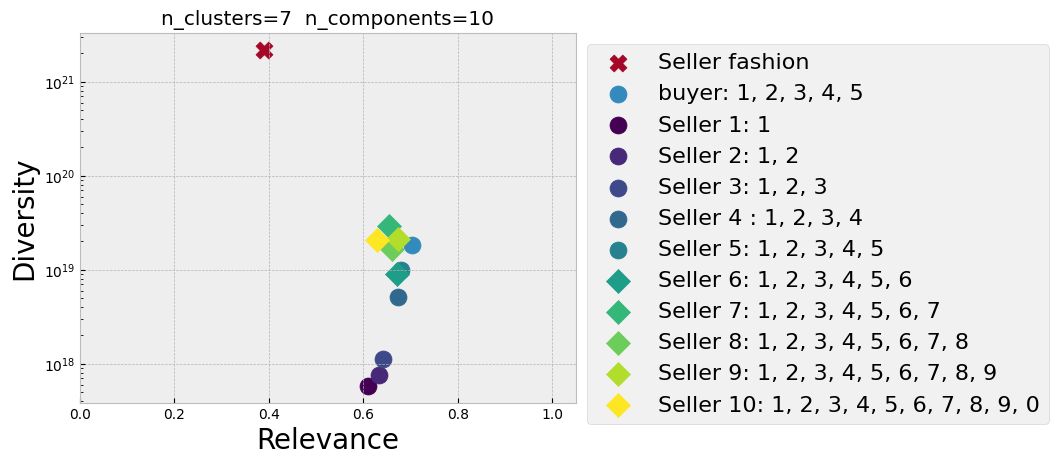

/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36

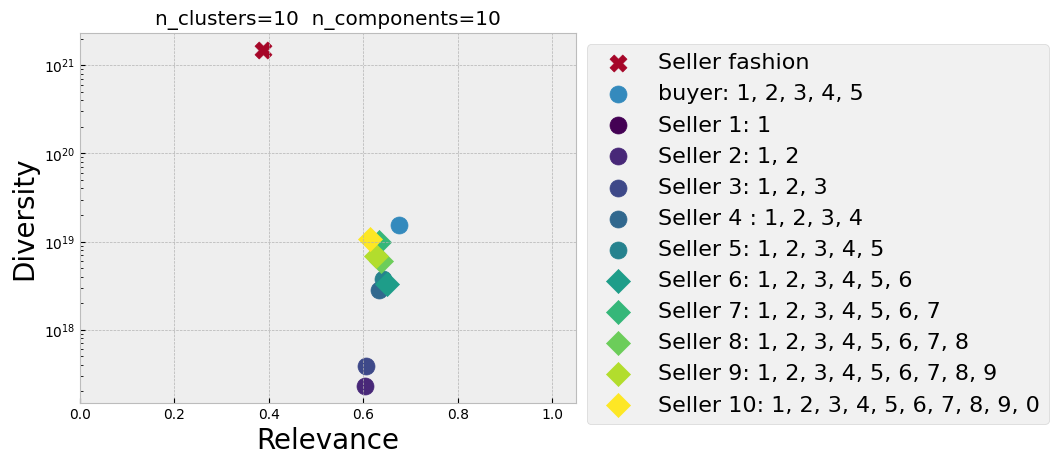

/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36: RuntimeWarning: invalid value encountered in sqrt
  volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)
/u/luchar/data-valuation/valuation.py:36

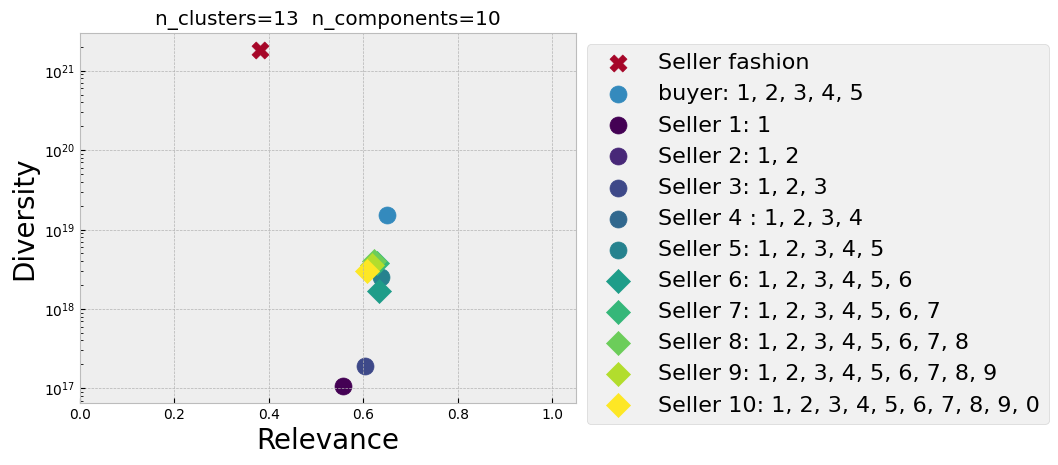

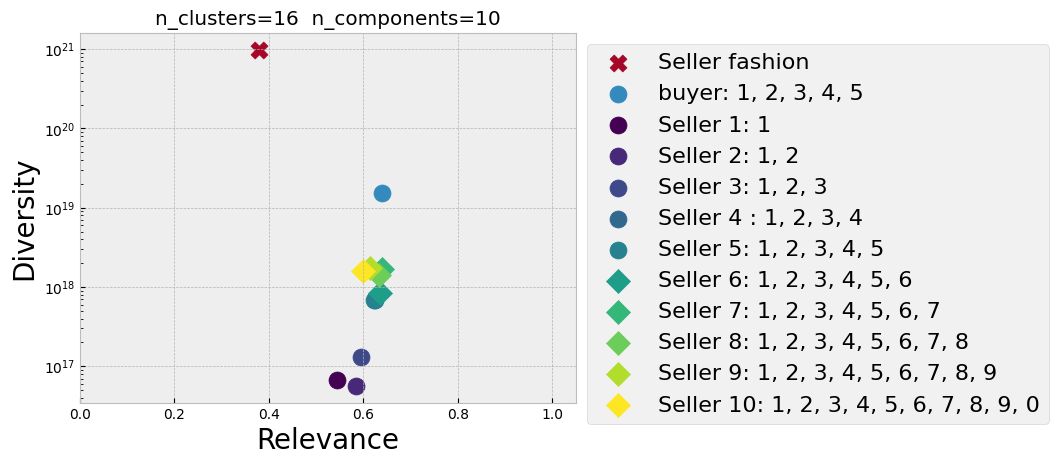

In [63]:
# n_clusters = 5
n_clusters = 10
n_components = 10

# for n_components in (5, 8, 10, 15, 20):
for n_clusters in (1, 2, 3, 4, 5, 7, 10, 13, 16):
# for n_clusters in (30, 50):
    s = 150
    plt.scatter(*cluster_valuation(buyer_data, np.array(fashion_seller_features, dtype=np.double), n_clusters=n_clusters, n_components=n_components), color='C1', s=s, marker='X', label='Seller fashion')
    plt.scatter(*cluster_valuation(buyer_data, buyer_data, n_clusters=n_clusters, n_components=n_components), label='buyer: 1, 2, 3, 4, 5', s=s, marker='o')
    plt.scatter(*cluster_valuation(buyer_data, seller_1_data, n_clusters=n_clusters, n_components=n_components), color=colors[0], s=s, marker='o', label='Seller 1: 1')
    plt.scatter(*cluster_valuation(buyer_data, seller_2_data, n_clusters=n_clusters, n_components=n_components), color=colors[1], s=s, marker='o', label='Seller 2: 1, 2')
    plt.scatter(*cluster_valuation(buyer_data, seller_3_data, n_clusters=n_clusters, n_components=n_components), color=colors[2], s=s, marker='o', label='Seller 3: 1, 2, 3')
    plt.scatter(*cluster_valuation(buyer_data, seller_4_data, n_clusters=n_clusters, n_components=n_components), color=colors[3], s=s, marker='o', label='Seller 4 : 1, 2, 3, 4')
    plt.scatter(*cluster_valuation(buyer_data, seller_5_data, n_clusters=n_clusters, n_components=n_components), color=colors[4], s=s, marker='o', label='Seller 5: 1, 2, 3, 4, 5')
    plt.scatter(*cluster_valuation(buyer_data, seller_6_data, n_clusters=n_clusters, n_components=n_components), color=colors[5], s=s, marker='D', label='Seller 6: 1, 2, 3, 4, 5, 6')
    plt.scatter(*cluster_valuation(buyer_data, seller_7_data, n_clusters=n_clusters, n_components=n_components), color=colors[6], s=s, marker='D', label='Seller 7: 1, 2, 3, 4, 5, 6, 7')
    plt.scatter(*cluster_valuation(buyer_data, seller_8_data, n_clusters=n_clusters, n_components=n_components), color=colors[7], s=s, marker='D', label='Seller 8: 1, 2, 3, 4, 5, 6, 7, 8')
    plt.scatter(*cluster_valuation(buyer_data, seller_9_data, n_clusters=n_clusters, n_components=n_components), color=colors[8], s=s, marker='D', label='Seller 9: 1, 2, 3, 4, 5, 6, 7, 8, 9')
    plt.scatter(*cluster_valuation(buyer_data, seller_10_data, n_clusters=n_clusters, n_components=n_components),color=colors[9], s=s, marker='D', label='Seller 10: 1, 2, 3, 4, 5, 6, 7, 8, 9, 0')
    plt.yscale('log')
    plt.xlim(0.0, 1.05)
    plt.xlabel('Relevance', fontsize=20)
    plt.ylabel('Diversity', fontsize=20)
    plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.00, 1.00), ncol=1)
    plt.title(f'{n_clusters=}  {n_components=}')
    plt.savefig(f'figures/cluster-{n_clusters=}-{n_components=}.png', bbox_inches='tight')
    plt.show()

break down relevance into proportion and similarity 
- cluster buyers and sellers 
- pairwise distance between clusters
- affinity score
- diverstiy and relvance for each cluster
- weighted combination of pairwise distances (weight proportional to size of cluster)
- kernel trick / approximation / iterative approach
- edge cases / failure analysis

In [52]:
KM.cluster_centers_


array([[-4.82729854, -1.62111337, -2.27875565, ..., -4.45724368,
        -1.10731641,  5.25624483],
       [-4.07878937, -0.83040697,  1.1767146 , ..., -0.92686471,
         1.0530651 , -0.63134949],
       [-8.4524398 , -1.96308928, -1.52401848, ..., -3.36313783,
        -0.88340687,  3.32537263],
       ...,
       [-4.77818195, -0.68331839,  0.51113618, ..., -1.87576227,
        -1.40685149,  0.91294441],
       [-2.41028847,  0.7709861 ,  0.37490295, ..., -0.9074569 ,
         0.69837032,  0.0457947 ],
       [-4.74735455, -0.42498818, -1.55889567, ..., -1.29029975,
        -2.50496836,  3.76694889]])